# Black_Jack Optimal Strategy Using Q-Learning

In [1]:
import numpy as np

# Add this line to fix the bool8 issue
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import gym
from collections import defaultdict
import sys
import json
!pip install gym


q-learning algorithim

In [2]:

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import gym
from collections import defaultdict #initialize q-values

env = gym.make('Blackjack-v1')

#exploit vs explore using epsilon greedy
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

#algorithim implentation
def q_learning(num_episodes=200000, alpha=0.01, gamma=0.15, epsilon=1.0, epsilon_min=0.15, epsilon_decay=0.99): #
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #every action-state's q-value is initially 0
    rewards_all_episodes = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done: #choose an action
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done, _ = env.step(action) #calculate next state, reward, and if game is over
            total_reward += reward

            best_next_action = np.argmax(Q[next_state]) #use q values to determine next best action
            td_target = reward + gamma * Q[next_state][best_next_action] #what q value should be
            td_delta = td_target - Q[state][action] #q value prediction error
            Q[state][action] += alpha * td_delta #calculate and store new value

            #update state
            state = next_state

        rewards_all_episodes.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay) #decay epsilon greedy


    #policy - dict mapping each state to optimal action
    policy = dict((state, np.argmax(actions)) for state, actions in Q.items())
    return Q, policy, rewards_all_episodes





/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


model training

In [3]:
#learning rate is 0.01, discount factor is 0.15
#epsilon decreases by 1% after each iteration to increase exploitation

Q, policy, rewards = q_learning(
    num_episodes=200000,  # or more
    alpha=0.01,
    gamma=0.15,
    epsilon=1.0,
    epsilon_min=0.15,
    epsilon_decay=0.99
)


plot average win rate

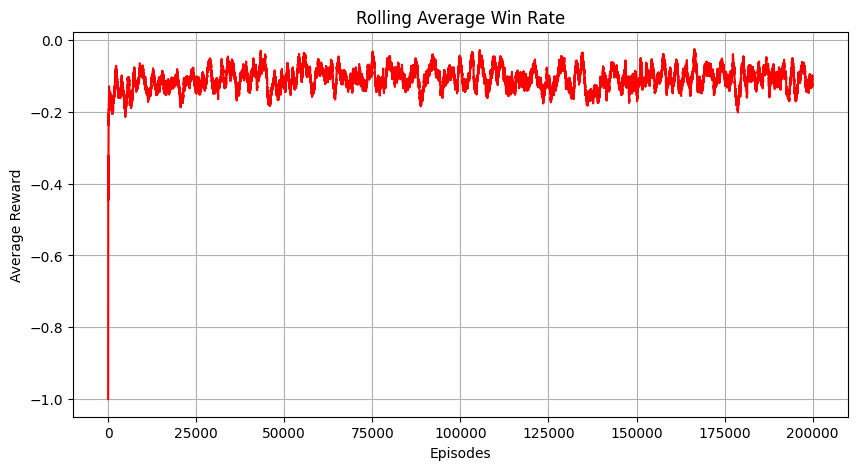

In [4]:

import matplotlib.pyplot as plt

def plot_win_rate(rewards, window=1000):
    win_rates = []
    for i in range(len(rewards)):
        if i < window:
            win_rates.append(np.mean(rewards[:i+1]))
        else:
            win_rates.append(np.mean(rewards[i-window+1:i+1]))

    plt.figure(figsize=(10, 5))
    plt.plot(win_rates, color = 'red')
    plt.title("Rolling Average Win Rate")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()

plot_win_rate(rewards)


heat map visualization (usuable vs unusable aces)

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def plot_policy_split(policy):
    grid_usable = np.full((10, 22), np.nan)
    grid_non_usable = np.full((10, 22), np.nan)

    for (player_sum, dealer_card, usable_ace), action in policy.items():
        if 12 <= player_sum <= 21 and 1 <= dealer_card <= 10:
            if usable_ace:
                grid_usable[dealer_card - 1, player_sum] = action
            else:
                grid_non_usable[dealer_card - 1, player_sum] = action

    cmap = colors.ListedColormap(['#d3d3d3', '#c3e6cb'])  # Gray = Stick, Green = Hit
    bounds = [-0.5, 0.5, 1.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    im1 = ax1.imshow(grid_usable.T, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    ax1.set_title('Policy After 200,000 Episodes (Usable Ace)')
    ax1.set_xlabel('Dealer Card Shown')
    ax1.set_ylabel('Player Hand Value')
    ax1.set_xticks(np.arange(10))
    ax1.set_yticks(np.arange(12, 22))
    ax1.set_xticklabels(np.arange(1, 11))
    ax1.set_yticklabels(np.arange(12, 22))
    ax1.grid(True, which='both', color='white', linewidth=1)

    im2 = ax2.imshow(grid_non_usable.T, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    ax2.set_title('Policy After 200,000 Episodes (No Usable Ace)')
    ax2.set_xlabel('Dealer Card Shown')
    ax2.set_ylabel('Player Hand Value')
    ax2.set_xticks(np.arange(10))
    ax2.set_yticks(np.arange(12, 22))
    ax2.set_xticklabels(np.arange(1, 11))
    ax2.set_yticklabels(np.arange(12, 22))
    ax2.grid(True, which='both', color='white', linewidth=1)

    fig.colorbar(im2, ax=[ax1, ax2], ticks=[0, 1], label='0 = Stick, 1 = Hit')
    plt.tight_layout()
    plt.show()




<ipython-input-5-87fb7d2fd276>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


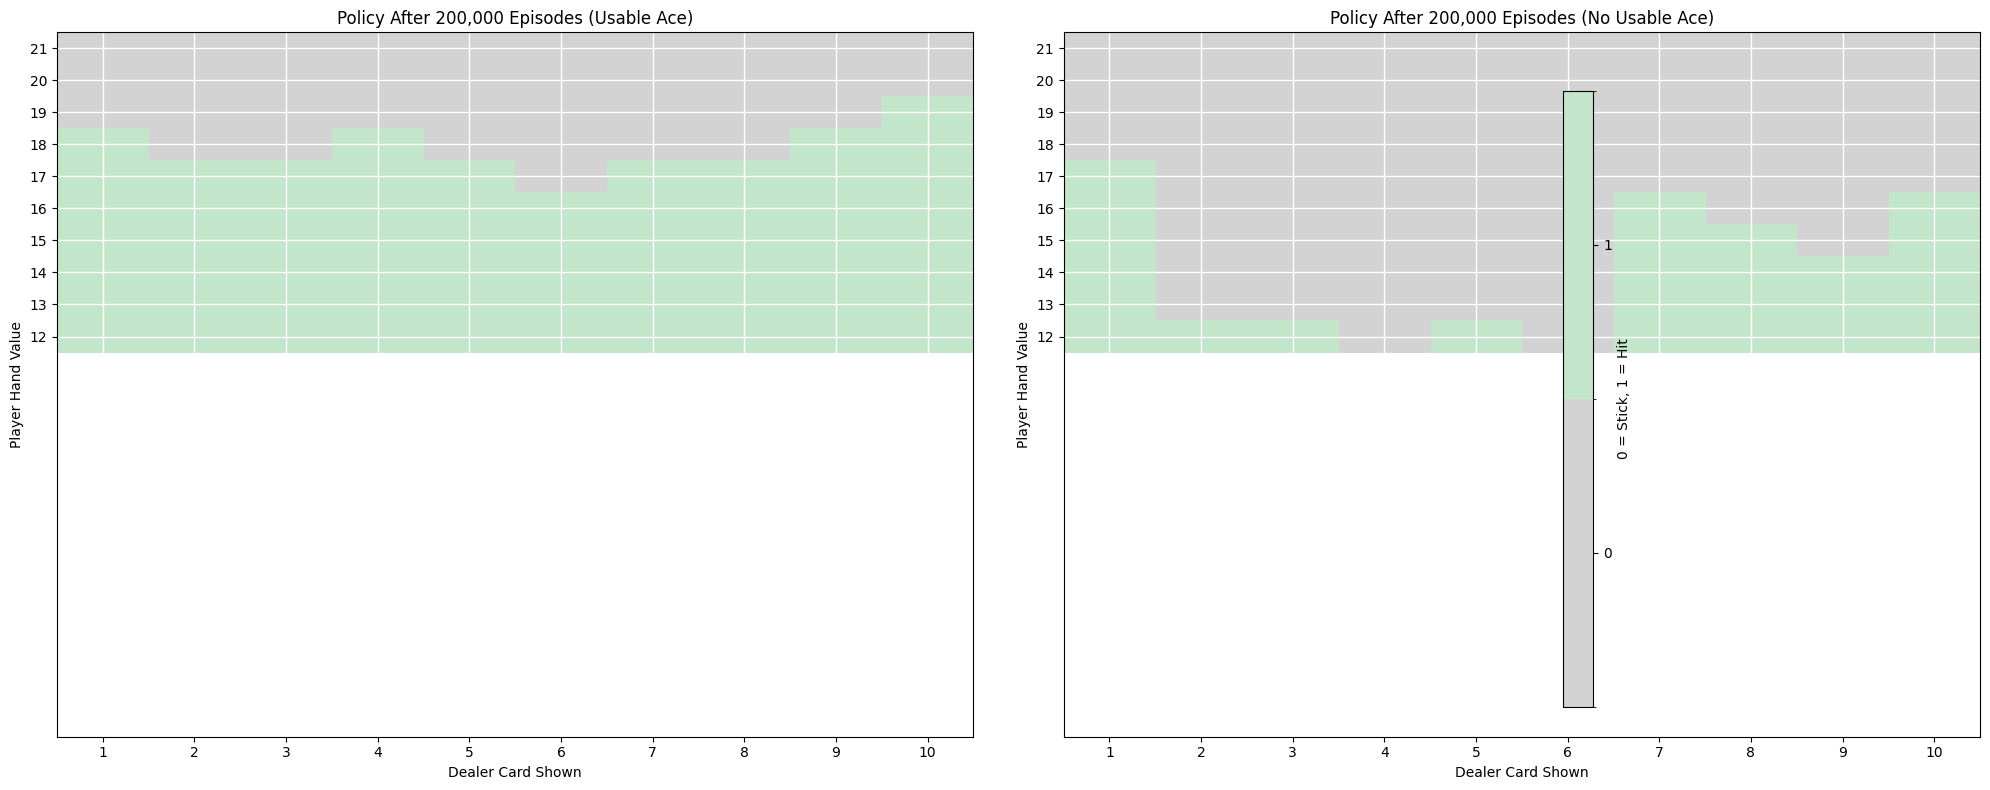

In [6]:
plot_policy_split(policy)

basic strategy heat maps

<ipython-input-7-acf427852279>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


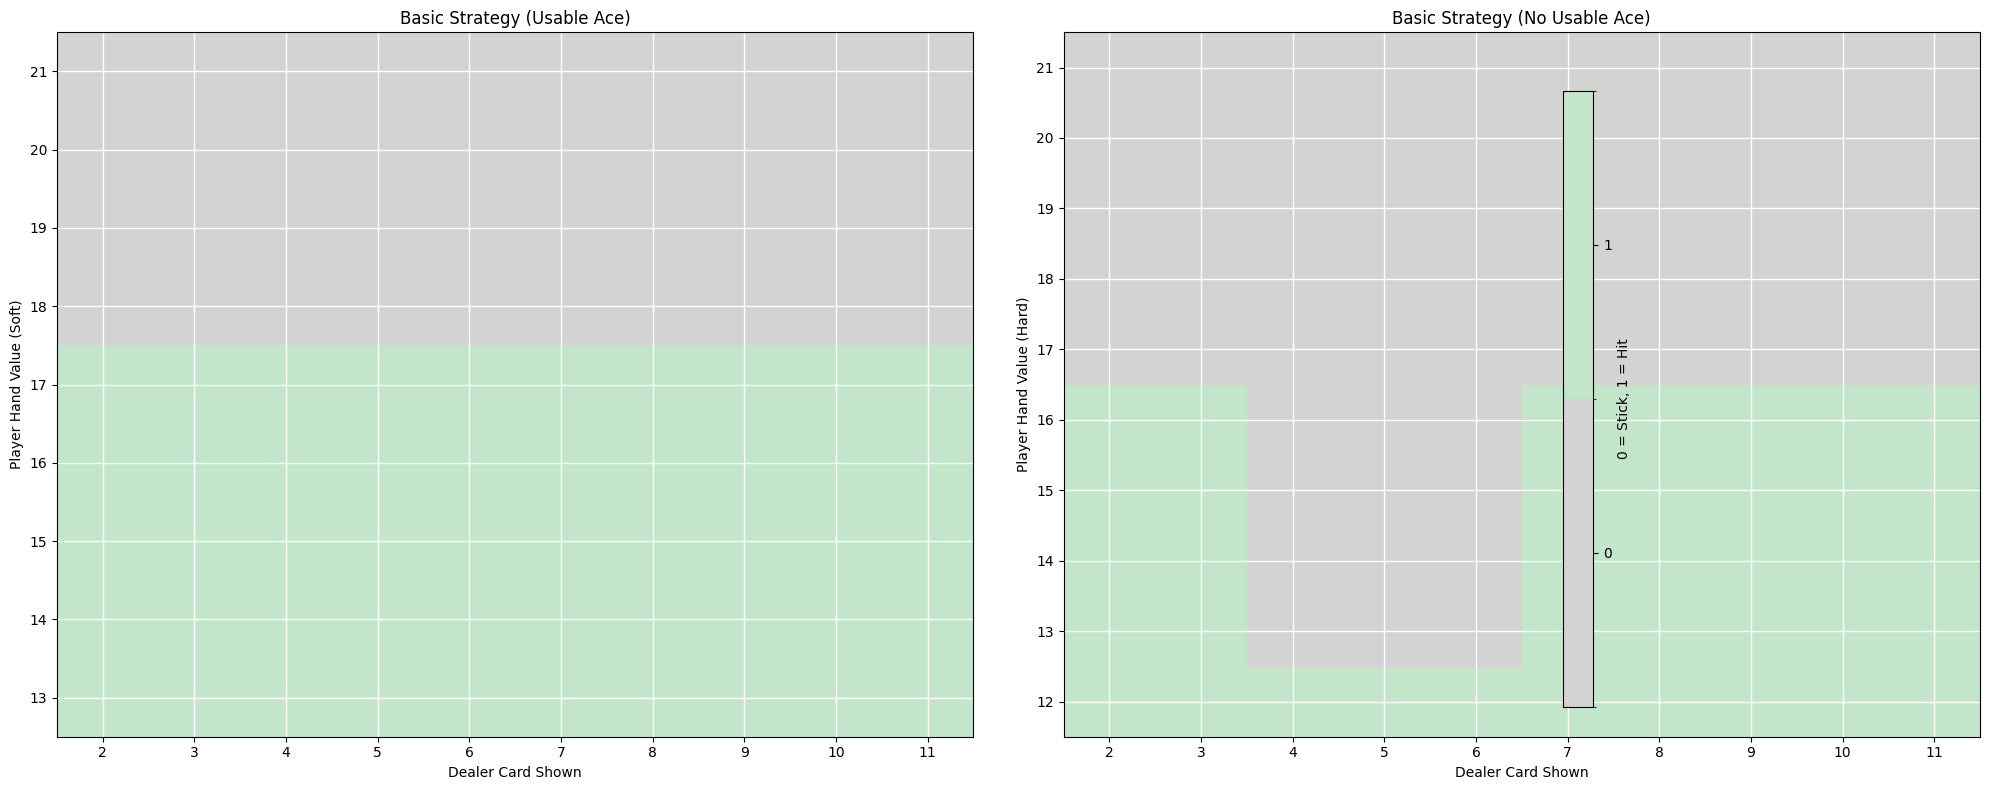

In [7]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def plot_basic_strategy():
    # Create a grid for hard totals (non-usable ace)
    # Rows: player hand value 12–21
    # Columns: dealer card showing 1–10 (ace = 1)
    basic_hard = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 12
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1],  # 13
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1],  # 14
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1],  # 15
        [1, 1, 0, 0, 0, 1, 1, 1, 1, 1],  # 16
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 17
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 18
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 19
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 20
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 21
    ])

    # Create a grid for soft totals (usable ace, player sum 13 to 21)
    basic_soft = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 13 (A,2)
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 14 (A,3)
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 15 (A,4)
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 16 (A,5)
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 17 (A,6)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 18 (A,7)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 19 (A,8)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 20 (A,9)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # 21 (A,10)
    ])

    cmap = colors.ListedColormap(['#d3d3d3', '#c3e6cb'])  # Gray = Stick, Green = Hit
    bounds = [-0.5, 0.5, 1.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot for soft hands
    im1 = ax1.imshow(basic_soft, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    ax1.set_title('Basic Strategy (Usable Ace)')
    ax1.set_xlabel('Dealer Card Shown')
    ax1.set_ylabel('Player Hand Value (Soft)')
    ax1.set_xticks(np.arange(10))
    ax1.set_yticks(np.arange(9))
    ax1.set_xticklabels(np.arange(2, 12))
    ax1.set_yticklabels(np.arange(13, 22))
    ax1.grid(True, which='both', color='white', linewidth=1)

    # Plot for hard hands
    im2 = ax2.imshow(basic_hard, cmap=cmap, norm=norm, origin='lower', aspect='auto')
    ax2.set_title('Basic Strategy (No Usable Ace)')
    ax2.set_xlabel('Dealer Card Shown')
    ax2.set_ylabel('Player Hand Value (Hard)')
    ax2.set_xticks(np.arange(10))
    ax2.set_yticks(np.arange(10))
    ax2.set_xticklabels(np.arange(2, 12))
    ax2.set_yticklabels(np.arange(12, 22))
    ax2.grid(True, which='both', color='white', linewidth=1)

    fig.colorbar(im2, ax=[ax1, ax2], ticks=[0, 1], label='0 = Stick, 1 = Hit')
    plt.tight_layout()
    plt.show()

# Run the plotting function
plot_basic_strategy()
